## Neural Network and Convolutional Neural Network Practice

In step 3-2, we want to implement computational graph concept into our NN and CNN program. Thus we have to rewrite all operations into layers. It's easier to compute the forward and backward propagation in this way. 

In [1]:
import numpy as np

### Helper functions

In [2]:
def softmax(x):
    if x.ndim == 2:
        x = x.T # convert x_i from row to column
        x = x - np.max(x, axis = 0) # axis = 0: vertical 
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        return y.T # transpose back to original format

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

# input type is one-hot-encoding label
def cross_entropy_error(y, t):
    delta = 1e-7
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y+delta)) / batch_size

### Computational Graph Style Layers

Practice computational graph style layer design. Implement Addition and Multiplication operations.

In [3]:
# forward: x + y = z
# backward: df/dx = df/dz * dz/dx
# dz/dx = 1
class AddLayer():
    def __init__(self):
        pass
    def forward(self, x, y):
        return x + y
    def backward(self, dfdz):
        return dfdz*1, dfdz*1

In [4]:
# forward: x * y = z
# backward: df/dx = df/dz * dz/dx
# dz/dx = y
class MulLayer():
    def __init__(self):
        self.x = self.y = None
    def forward(self, x, y):
        self.x, self.y = x, y
        return x * y
    def backward(self, dfdz):
        return dfdz * self.y, dfdz * self.x

### Test Addition and Multiplication Layers

Test case using following equation: $f(x_i,y_i,r) = (x_1*y_1+x_2*y_2)*r$
First compute the forward value $(x_1*y_1+x_2*y_2)*r$
Second compute the backward value $df/dr = (x_1*y_1+x_2*y_2)$ and $df/d(x_1y_1+x_2y_2) = r$

In [5]:
# initiate values
x1, y1, x2, y2, r = 100, 2, 150, 3, 1.1

# compute forward, ie f = ( x1*y1 + x2*y2 ) * r
# initiate layers according to corresponding computation graph
x1y1_layer = x2y2_layer = xyr_layer = MulLayer()
x1y1_x2y2_layer = AddLayer()

# computate forward
x1y1 = x1y1_layer.forward(x1,y1)
x2y2 = x2y2_layer.forward(x2,y2)
x1y1_x2y2 = x1y1_x2y2_layer.forward(x1y1,x2y2)
xyr = xyr_layer.forward(x1y1_x2y2, r)

print('Forward check: ')
print('( x1*y1 + x2*y2 ) * r =' + str(xyr))
print('')

# compute backward
df = 1
dall, dfdr = xyr_layer.backward(df)
dx1y1, dx2y2 = x1y1_x2y2_layer.backward(dall)
dx1, dy1 = x1y1_layer.backward(dx1y1)
dx2, dy2 = x2y2_layer.backward(dx2y2)

print('Backward check: ')
print('x1*y1 + x2*y2 = ' + str(x1y1_x2y2))
print('r = ' + str(r))
print('df/dr =' + str(dfdr))
print('df/dxy = ' + str(dall))

Forward check: 
( x1*y1 + x2*y2 ) * r =715.0000000000001

Backward check: 
x1*y1 + x2*y2 = 650
r = 1.1
df/dr =650
df/dxy = 1.1


### Relu and Sigmoid Layer

In [6]:
# forward: z = x if x > 0, 0 if x <= 0
# backward: df/dx = df/dz * dz/dx, 
# dz/dx = 1 if x > 0, 0 if x <= 0
class Relu():
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dfdz):
        out = dfdz.copy()
        out[self.mask] = 0
        return out

In [7]:
# forward: z = 1 / (1 + exp(-x) ) 
# backward: 
# dz/dx = z^2 * exp(-x) = 1/(1+exp(-x))^2 * exp(-x) 
#       = 1/(1+exp(-x)) * exp(-x)/(1+exp(-x)) 
#       = z * (1-z)
class Sigmoid():
    def __init__(self):
        self.out = None
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    def backward(self, dfdz):
        return dfdz * (1- self.out) * self.out

### Affine Layer

On step 3-1, we propagated values between layers using matrix operation: $ X\cdot W + B = Y$. We can rewrite these operations in layer style we just did above. This layer usually called Affine Layer in Neural Netwrok.

In [8]:
class Affine():
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.x = self.dW = self.db = None
    
    def forward(self,x):
        self.x = x
        return np.dot(self.x, self.W) + self.b
    
    def backward(self,dfdy):
        dx = np.dot(dfdy, self.W.T)
        self.dW = np.dot(self.x.T, dfdy)
        self.db = np.sum(dfdy, axis = 0)
        return dx

In [9]:
class SoftmaxWithError():
    def __init__(self):
        self.error = None
        self.y_h = None
        self.y = None
    
    def forward(self, x, y):
        self.y = y
        self.y_h = softmax(x)
        self.error = cross_entropy_error(self.y_h, self.y)
        return self.error
    
    def backward(self):
        batch_data_size = self.y.shape[0]
        dx = (self.y_h - self.y) / batch_data_size
        return dx

### Rewrite Two Layer Network Using Affine Layer

In [10]:
# use ordered dictionary to store weights and bias in order
# eaiser to call when doing forward and backward propagation
from collections import OrderedDict

In [11]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        
        # 1st layer size: from input to cell size
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        
        # 2nd layer size: from cell size to output size
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # generate layersz
        # input -> Affine Later 1 with W1 b1 
        #       -> Relu Layer 1 
        #       -> Affine Layer 2 with W2 b2
        #       
        # if we need more layers, we can add here
        #       -> Relu layer 2
        #       -> Affine Layer n with Wn bn
        #       -> Relu Layer n 
        #
        #       -> results here is evaluation scores
        #       -> Apply Softmax layer only if we want fianl prediction, not in training stage?
        self.layers = OrderedDict()
        self.layers['Affine_layer_1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu_layer_1' ] = Relu()
        self.layers['Affine_layer_2'] = Affine(self.params['W2'], self.params['b2'])
        self.last_layer = SoftmaxWithError()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def error(self, x, y):
        y_h = self.predict(x)
        return self.last_layer.forward(y_h, y)
    
    def accuracy(self, x, y):
        y_h = self.predict(x)
        # convert one-hat-encode to one value
        y_h , y = np.argmax(y_h, axis = 1), np.argmax(y, axis = 1) 
        return np.sum(y_h == y)/float(x.shape[0])
    
    def gradient(self, x, y):
        # apply forward propagation to get error
        self.error(x, y)
        
        # then apply backward prapagation to get gradients
        # last layer backward propagate dout
        dout = self.last_layer.backward()
        
        # call layers in backward order
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine_layer_1'].dW, self.layers['Affine_layer_1'].db
        grads['W2'], grads['b2'] = self.layers['Affine_layer_2'].dW, self.layers['Affine_layer_2'].db
        
        return grads

### Apply 2 layers model to train and test MNIST data

In [12]:
import os
from mnist import MNIST
mnidata = MNIST(os.getcwd()+'/Data')
train_img, train_lab = mnidata.load_training()
test_img, test_lab = mnidata.load_testing()

In [13]:
# convert python list to to numpy array
train_data, train_label = np.array(train_img), np.array(train_lab)
test_data, test_label = np.array(test_img), np.array(test_lab)

# normalize image
train_data, test_data = train_data.astype(np.float32), test_data.astype(np.float32)
train_data /= 255.0
test_data /= 255.0

# convert label to one hot encoding
def one_hot_encoding(labels, num_of_classes):
    res = np.eye(num_of_classes)[np.array(labels).reshape(-1)]
    return res.reshape(list(labels.shape)+[num_of_classes])

train_label, test_label = one_hot_encoding(train_label, 10), one_hot_encoding(test_label, 10)

In [14]:
# initiate two layer neural network
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [15]:
# parameters
iteration_number = 10000
train_data_size = train_data.shape[0]
batch_data_size = 100
learning_rate = 0.1

train_error_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = train_data_size/batch_data_size

In [16]:
# training
for i in range(iteration_number):
    # mini-batch, using random function to randomly choicing data
    batch_selection = np.random.choice(train_data_size, batch_data_size)
    traing_data_batch = train_data[batch_selection]
    train_label_batch = train_label[batch_selection]
    
    # compute gradient
    grads = network.gradient(traing_data_batch, train_label_batch)
    
    # update weights
    # New Weights = Weights - learning_rate * Weights gradients
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grads[key]
        
    # record error
    error = network.error(traing_data_batch, train_label_batch)
    train_error_list.append(error)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(train_data, train_label)
        test_acc = network.accuracy(test_data, test_label)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("---- " + str(i//iter_per_epoch)[:-2] +" epoch" "----" )
        print("Training set accuracy: " + str(train_acc))
        print("Testing set accuracy: " + str(test_acc))

---- 0 epoch----
Training set accuracy: 0.05991666666666667
Testing set accuracy: 0.0589
---- 1 epoch----
Training set accuracy: 0.9052833333333333
Testing set accuracy: 0.9113
---- 2 epoch----
Training set accuracy: 0.9230666666666667
Testing set accuracy: 0.9227
---- 3 epoch----
Training set accuracy: 0.9385166666666667
Testing set accuracy: 0.9365
---- 4 epoch----
Training set accuracy: 0.9476333333333333
Testing set accuracy: 0.946
---- 5 epoch----
Training set accuracy: 0.9537
Testing set accuracy: 0.9525
---- 6 epoch----
Training set accuracy: 0.9562666666666667
Testing set accuracy: 0.9544
---- 7 epoch----
Training set accuracy: 0.9616
Testing set accuracy: 0.958
---- 8 epoch----
Training set accuracy: 0.96515
Testing set accuracy: 0.961
---- 9 epoch----
Training set accuracy: 0.9673
Testing set accuracy: 0.9624
---- 10 epoch----
Training set accuracy: 0.96825
Testing set accuracy: 0.9622
---- 11 epoch----
Training set accuracy: 0.9718333333333333
Testing set accuracy: 0.9642
--

### Plotting Results

In [17]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Training Error')

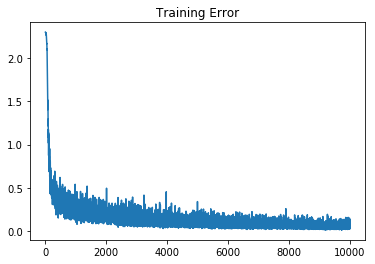

In [18]:
_ = plt.plot(train_error_list)
plt.title('Training Error')

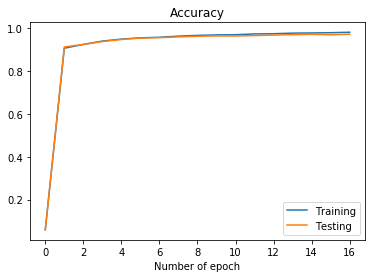

In [19]:
_ = plt.plot(train_acc_list)
_ = plt.plot(test_acc_list)
_ = plt.legend(['Training','Testing'])
_ = plt.title('Accuracy')
_ = plt.xlabel('Number of epoch')

In [20]:
def squareFormat(x):
    square = np.array(x)
    square.resize(28,28)
    return square
    
def showImg(x,label):
    plt.imshow(x, cmap = 'gray')
    plt.title('Predicted digit: '+ str(label))
    plt.xticks([])
    plt.yticks([])

In [21]:
y_h = network.predict(test_data)
y_h = np.argmax(y_h, axis = 1)
y = np.argmax(test_label, axis = 1)

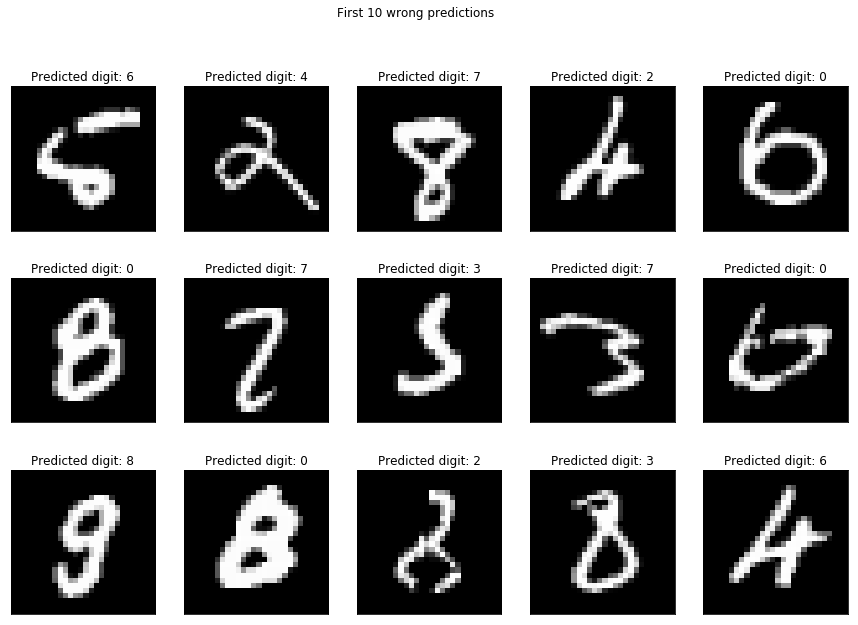

In [22]:
img = test_data[y_h!=y][0:15]
pre = y_h[y_h!=y][0:15]

fig = plt.figure(figsize = (15,10))
_ = fig.suptitle('First 10 wrong predictions')
for i in range(1,16):
    plt.subplot(3,5,i)
    showImg(squareFormat(img[i-1]), pre[i-1])